In [1]:
import os

import matplotlib.pyplot as plt
import tifffile as tf
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import scipy.optimize as optimize
import scipy.signal as signal

import skimage.measure as measure

import line_utils

In [2]:
# Establish the path the Excel file
base_path = "/Users/zachcm/Documents/Projects/ExM_Nadja/01_Macros_Analysis/"
workbook = "20241008_septin2_tubulin.xlsx"
workbook_path = os.path.join(base_path, workbook)
expected_colnames=['Distance_(microns)', 'MTs', 'septin2', 'DAPI']

In [3]:
# Load the table of contents
toc = pd.read_excel(workbook_path, sheet_name="ToC + P-t-p", header=2)

In [4]:
# load FWHM_along, which contains other statistics
metrics = pd.read_excel(workbook_path, sheet_name="FWHM_along", header=0).dropna(axis=0)

In [5]:
metrics = line_utils.merge_df_information(toc, 
                                          metrics, 
                                          id_key="Label", 
                                          mapped_keys=["dX (µm)", "dX (pxl)", "X1", "X2", "Angle","X","Y","length"])

In [6]:
# Let's load all of the normal sheets...
sheet_names = ["Septin2_RC_along", "Septin2_CS_along", "Septin2_RS_along", 
               "Septin2_SM_along", "Septin2_BA_along", "Septin2_A_along"]

res = {}
for sheet_name in sheet_names:
    line_utils.load_line_profiles(workbook_path, sheet_name, expected_colnames=expected_colnames, res=res)

In [7]:
# Now let's get the original images 
import glob

max_proj_path = "/Volumes/Ries_Ewers/Septin2-GFP/MaxIPs"
max_proj_files = glob.glob(max_proj_path+"/*.tif")

/Users/zachcm/Code/expansion-analysis/line_utils.py:243: RuntimeWarning: invalid value encountered in add
  return np.real((r*np.exp((-5*np.pi*(2j*r*t + 5*np.pi*sig**2))/(2.*r**2))*(12*spec.jv(1,5*np.pi)*(spec.erf((r*(r + t) - 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r**2 - r*t + 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + (spec.erf((r**2 - r*t - 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((10j*np.pi*t)/r)) + 60*spec.jv(1,np.pi)*((spec.erf((r**2 - r*t - 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((6*np.pi*(1j*r*t + 2*np.pi*sig**2))/r**2) + (spec.erf((r*(r + t) - 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r**2 - r*t + 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((4*np.pi*(1j*r*t + 3*np.pi*sig**2))/r**2)) + 20*spec.jv(1,3*np.pi)*((spec.erf((r**2 - r*t - 3j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 3j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp

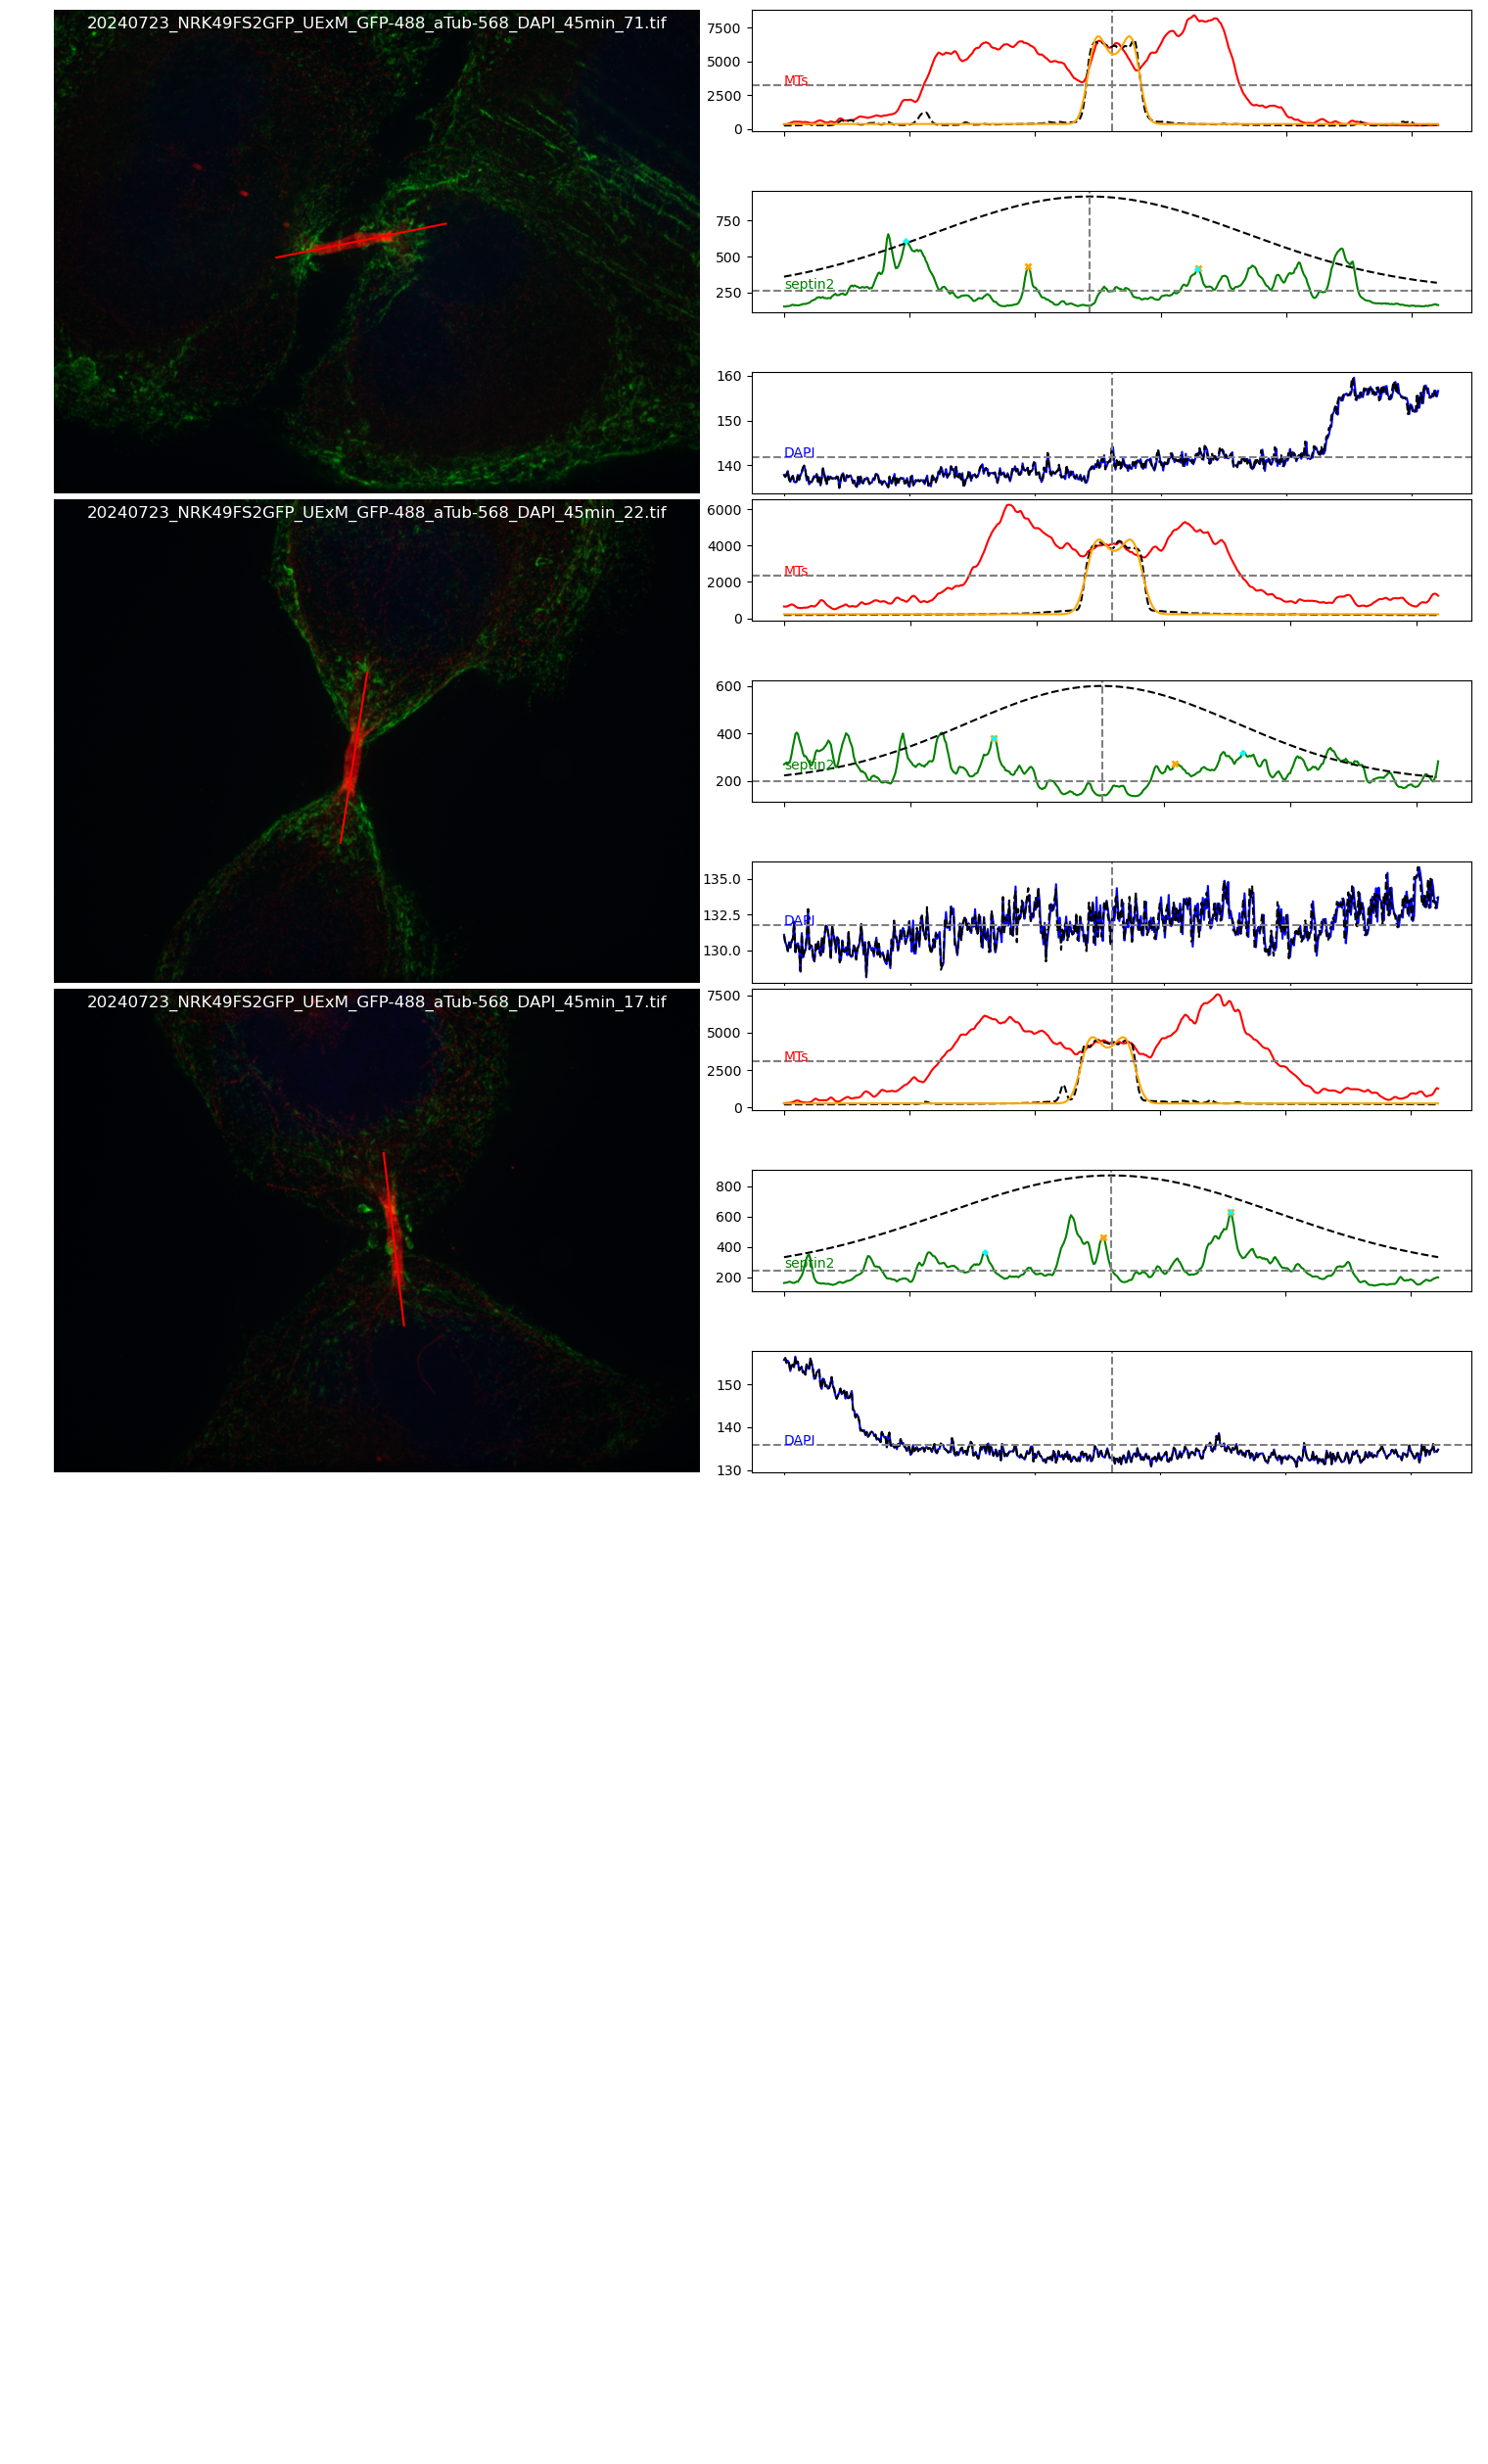

In [ ]:
from skimage.filters import threshold_otsu

N = 5
# fig, ax = plt.subplots(16,N,figsize=(20,4*16))
fig = plt.figure(figsize=(15,5*N))
subfigs = fig.subfigures(N,1)
j = 0
metrics['dX2'] = np.nan
metrics['X12'] = np.nan
metrics['X22'] = np.nan
for i, ml in metrics.iterrows():
    # Get the image associated with this row
    im = None
    for fn in max_proj_files:
        if ml["Label"] in fn:
            im = tf.imread(fn)
            break

    # get x, y, angle, length for this row
    x, y, angle, length = ml[["X", "Y", "Angle", "length"]]

    # Compute the line end points
    xl, xu, yl, yu = line_utils.get_line_profile_endpoints(x, y, angle, length)

    # get the corresponding line profiles
    for key, val in res.items():
        if ml["Label"] in key:
            lp = val

    chs = measure.profile_line(im.T, 
                              [xl, yu], 
                              [xu, yl], 
                              linewidth=25)

    mt, septin, dapi = chs.T

    # line profile metrics we'll use later
    mt_mean,  mt_mid= np.mean(mt), len(mt)/2
    dapi_mean, dapi_mid = np.mean(dapi), len(dapi)/2
    min_septin, max_septin = np.min(septin), np.max(septin)

    # Find peaks in the septin channel
    septin_threshold = np.min(septin)+np.std(septin)
    peaks, peak_props = signal.find_peaks(septin, height=septin_threshold, width=3)
    
    # Center the search for peaks on the peak of microtubule signal
    mt_threshold = np.mean(mt) # np.min(mt)+np.std(mt)
    mt_idxs = np.flatnonzero(mt>mt_threshold)
    profile_center = np.sum(mt_idxs*mt[mt_idxs])/(mt[mt_idxs].sum())  # np.mean(np.argwhere(mt>mt_threshold))
    # sig = np.sum(mt>mt_threshold)/2 #(2.3548200450309493)
    sig = (np.diff(np.flatnonzero(mt>mt_threshold)[[0,-1]]))/2 #2.3548200450309493

    # weighting discourages use of tall peaks at line profile extremities
    w = np.exp(-((peaks-profile_center)**2)/(2*sig*sig)) # *septin_grad
    w = w*(mt[peaks]/mt[peaks].sum())

    # select two peaks, on either side of profile_center
    weighted_peaks = (peak_props['peak_heights']-septin_threshold)*w
    # peak_sharpness = (peak_props['peak_heights']-septin_threshold)/(peak_props['widths']+1)
    # weighted_peaks = peak_sharpness*w
    peaks_lower = peaks[peaks<=profile_center]
    peaks_upper = peaks[peaks>profile_center]
    try:
        p0 = peaks_lower[np.argmax(weighted_peaks[peaks<=profile_center])]
    except ValueError:
        p0 = 0
    try:
        p1 = peaks_upper[np.argmax(weighted_peaks[peaks>profile_center])]
    except ValueError:
        p1 = 0
    peaks = np.array([p0, p1])
    
    # Get the distance between the peaks
    try:
        dX2 = np.abs(np.diff(peaks)[0])
    except IndexError:
        dX2 = 0
    metrics.loc[i,'X12'] = p0
    metrics.loc[i,'X22'] = p1
    metrics.loc[i,'dX2'] = dX2

    # Now get the orthogonal line profile at the line center
    xl2, xu2, yl2, yu2 = line_utils.get_line_profile_endpoints(x, y, angle-90, length)
    chs = measure.profile_line(im.T, 
                              [xl2, yu2], 
                              [xu2, yl2], 
                              linewidth=25)
    mt, _, _ = chs.T

    # --------- Fit tubule ---------
    r_outer = np.sum(mt>(np.max(mt)/2))/2
    r_outer = np.sum(mt>np.mean(mt))/2
    p0 = [np.max(mt), len(mt)/2, 3, np.min(mt), r_outer, 0.95*r_outer]  # [A, mu, sig, b, r_outer, r_inner]
    res_lsq = optimize.least_squares(line_utils.shape_res, 
                                     p0, 
                                     args=(line_utils.gauss_convolved_annulus_approx, np.arange(mt.shape[0]), mt))
    metrics.loc[i,'diamM2'] = 2*res_lsq.x[4]

    # --------- Fit Gaussian ---------
    # p0 = [np.max(mt), len(mt)/2, 3, np.min(mt)]  # A, mu, sig, b
    # res_lsq = optimize.least_squares(line_utils.shape_res, 
    #                                  p0, 
    #                                  args=(line_utils.gauss, np.arange(mt.shape[0]), mt))
    # metrics.loc[i,'diamM2'] = 2.3548200450309493*res_lsq.x[2]

    # (metrics.loc[i,'dX2'] != metrics.loc[i,'dX (pxl)']) or
    # (np.abs(metrics.loc[i,'diamM2'] - metrics.loc[i,'diamM']) > 10)
    if (j < (N-1)) and (np.abs(metrics.loc[i,'dX2'] - metrics.loc[i,'dX (pxl)']) > 50) and metrics.loc[i, 'Unnamed: 0'] == "SM":
        # print(f"Calculate difference: {metrics.loc[i,'dX2']} original difference: {metrics.loc[i,'dX (pxl)']}")
        maxidx = min(mt.shape[0], lp.shape[0])
        septin_weight = max_septin*np.exp(-((np.arange(maxidx)-profile_center)**2)/(2*sig*sig))+septin_threshold
        line_utils.image_with_profiles(subfigs[j], 
                                       im, xl, xu, yl, yu, 
                                       channel_names=expected_colnames[1:], linewidth=25,
                                       # precalc_channel_profiles=lp[["MTs", "septin2", "DAPI"]].to_numpy(),
                                       precalc_channel_profiles=np.vstack([mt[:maxidx], septin_weight[:maxidx], lp[["DAPI"]].to_numpy()[:maxidx,:].T]).T,
                                       precalc_peaks=[None, [peaks, [int(metrics.loc[i,'X1']), int(metrics.loc[i,'X2'])]], None],
                                       precalc_fits=[(line_utils.gauss_convolved_annulus_approx, res_lsq.x), None, None],
                                       precalc_means=[mt_mean,septin_threshold,dapi_mean],
                                       precalc_midpoints=[mt_mid,profile_center,dapi_mid],
                                       title = os.path.basename(fn),      
        )
        j += 1

    # if (j==5):
    #     break
    # if metrics.loc[i,'dX2'] != metrics.loc[i,'dX (pxl)']:
    #     break

    # if np.abs(metrics.loc[i,'diamM2'] - metrics.loc[i,'diamM']) > 10:
    #     break
    
    # break

fig.tight_layout()#pad=0.4, w_pad=0.5, h_pad=1.0)

69141.0


Text(0.5, 1.0, 'chi2_dist')

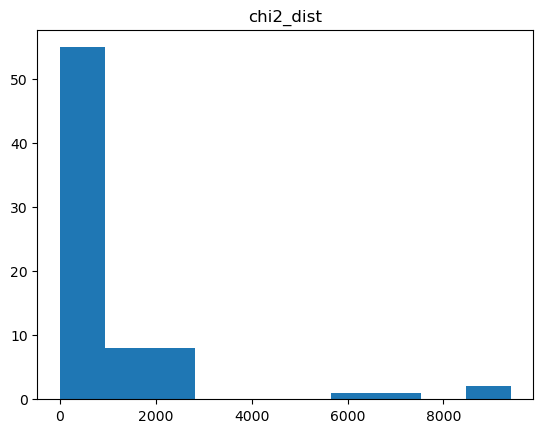

In [9]:
x1x1 = (metrics['X1']-metrics['X12'])**2
x1x2 = (metrics['X1']-metrics['X22'])**2
x2x1 = (metrics['X2']-metrics['X12'])**2
x2x2 = (metrics['X2']-metrics['X22'])**2

# compute the sum of the squares of the minimum distance pairings
chi2_dist = -1*np.ones(x1x1.shape[0])

# x1 is closer to x12, so we combine this with x2 to x22
chi2_dist[x1x1 < x1x2] = x1x1[x1x1 < x1x2] + x2x2[x1x1 < x1x2]
chi2_dist[x1x1 > x1x2] = x1x2[x1x1 > x1x2] + x2x1[x1x1 > x1x2]

print(chi2_dist.sum())
plt.hist(chi2_dist)
plt.title('chi2_dist')

Text(0.5, 1.0, '|dX (pxl) - dX2|')

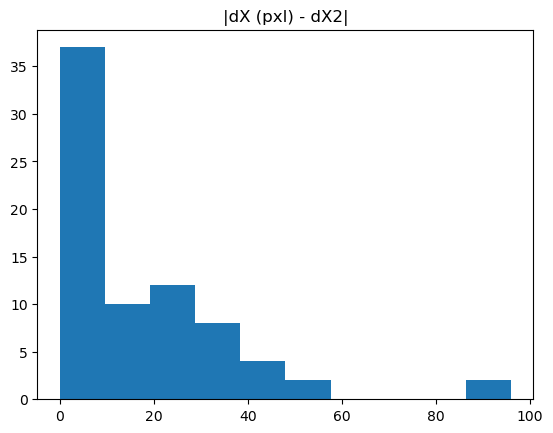

In [10]:
plt.hist(np.abs(metrics['dX (pxl)'] - metrics['dX2']))
plt.title('|dX (pxl) - dX2|')

<Axes: xlabel='Unnamed: 0', ylabel='dX2'>

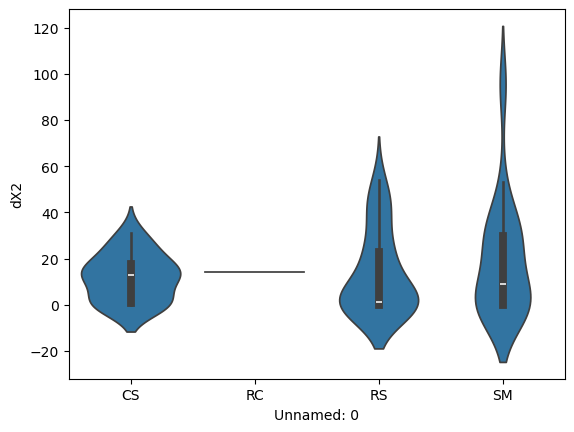

In [11]:
import seaborn as sns

sns.violinplot(metrics.groupby('Unnamed: 0')[['dX (pxl)', 'dX2']].diff(axis=1)[['dX2']].abs(), x="Unnamed: 0", y="dX2")

Text(0.5, 1.0, '|diamM - diamM2|')

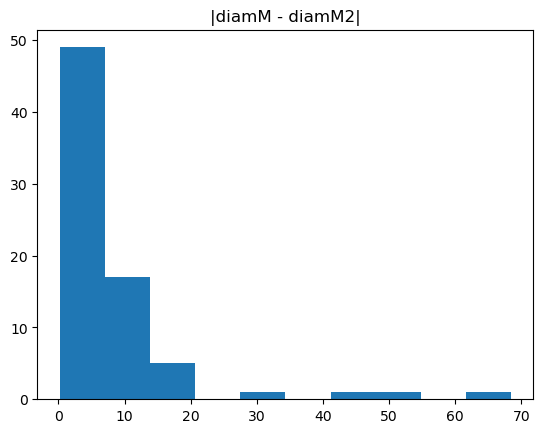

In [12]:
plt.hist(np.abs(metrics['diamM'] - metrics['diamM2']))
plt.title('|diamM - diamM2|')